# Modeling and Simulation in Python

Chapter 23

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [41]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from the previous chapter

In [9]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree

<Unit('degree')>

In [10]:
params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.3,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 20 * s)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [11]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [12]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [16]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [17]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

### Optimal launch angle

To find the launch angle that maximizes distance from home plate, we need a function that takes launch angle and returns range.

In [18]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

Let's test `range_func`.

In [9]:
%time range_func(45, params)

Wall time: 86.6 ms


<Quantity(102.72776151763686, 'meter')>

And sweep through a range of angles.

In [10]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    print(angle, x_dist)
    sweep[angle] = x_dist

20.0 79.96823513701818 meter
23.0 86.2962864918857 meter
26.0 91.59647908800756 meter
29.0 95.89089380357947 meter
32.0 99.20335822576214 meter
35.0 101.55668007973463 meter
38.0 102.97173880917646 meter
41.0 103.46740813177843 meter
44.0 103.060922479178 meter
47.0 101.7684506860653 meter
50.0 99.60572853320414 meter
53.0 96.58867331645769 meter
56.0 92.7339915489422 meter
59.0 88.05990483905572 meter
62.0 82.58716276454999 meter
65.0 76.34016117578483 meter
68.0 69.34714056465755 meter
71.0 61.63878192638946 meter
74.0 53.256101549629825 meter
77.0 44.246680677829886 meter
80.0 34.6702130194327 meter


Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

Saving figure to file figs/chap10-fig03.pdf


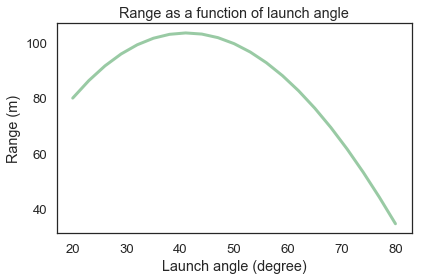

In [11]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [12]:
%time res = max_bounded(range_func, [0, 90], params)

Wall time: 345 ms


`res` is an `ModSimSeries` object with detailed results:

In [13]:
res

,values
fun,103.46837822354611 meter
status,0
success,True
message,Solution found.
x,41.1391
nfev,9


`x` is the optimal angle and `fun` the optional range.

In [14]:
optimal_angle = res.x * degree

<Quantity(41.139142795614596, 'degree')>

In [15]:
max_x_dist = res.fun

<Quantity(103.46837822354611, 'meter')>

### Under the hood

Read the source code for `max_bounded` and `min_bounded`, below.

Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

In [16]:
%psource max_bounded

In [17]:
%psource min_bounded

### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a params as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [47]:
params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.3,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 20 * s)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [63]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

def event_func2(state, t, system):
    """Stop when the x coordinate is 94.5.
    
    state: State object
    t: time
    system: System object
    
    returns: x-94.5 coordinate
    """
    x, y, vx, vy = state
    return x-94.5*m

def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    
    results, details = run_ode_solver(system, slope_func, events=event_func2)
    y_dist = get_last_value(results.y)
    return y_dist *m

Always test the slope function with the initial conditions.

In [64]:
system = make_system(params)
slope_func(system.init, 0, system)

(<Quantity(28.284271247461902, 'meter / second')>,
 <Quantity(28.284271247461902, 'meter / second')>,
 <Quantity(-5.878209892331404, 'meter / second ** 2')>,
 <Quantity(-15.678209892331406, 'meter / second ** 2')>)

In [65]:
height_func(45, params)

<Quantity(11.033479404035603, 'meter')>

Test your function with a launch angle of 45 degrees:

In [66]:
angles = linspace(20, 60, 21)
sweep = SweepSeries()

for angle in angles:
    y_dist = height_func(angle, params)
    print(angle, y_dist)
    sweep[angle] = y_dist

20.0 -9.25422996498987 meter
22.0 -6.788225896892498 meter
24.0 -4.409756488171514 meter
26.0 -2.1258944455008706 meter
28.0 0.05370823355909771 meter
30.0 2.1162270486049373 meter
32.0 4.044830453210379 meter
34.0 5.817700138995747 meter
36.0 7.406740959759269 meter
38.0 8.775868077832397 meter
40.0 9.8787093580999 meter
42.0 10.655484584450964 meter
44.0 11.028702178653951 meter
46.0 10.897117159051326 meter
48.0 10.127062219860157 meter
50.0 8.539682744229832 meter
52.0 5.891543287069091 meter
54.0 1.8440243244751997 meter
56.0 -4.086645117859284 meter
58.0 -12.608267462978931 meter
60.0 -24.813250682997616 meter


Now use `max_bounded` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

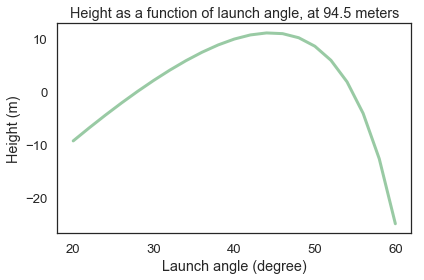

In [67]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Height (m)',
         title='Height as a function of launch angle, at 94.5 meters',
         legend=False)

In [68]:
%time res = max_bounded(height_func, [0, 90], params)

Wall time: 1.31 s


In [69]:
res

,values
fun,11.04782805563812 meter
status,0
success,True
message,Solution found.
x,44.5406
nfev,12


In [70]:
height_func(44.5406, params)

<Quantity(11.047828055531237, 'meter')>

With initial velocity 40 m/s and an optimal launch angle, the ball clears the Green Monster with a little room to spare.

Which means we can get over the wall with a lower initial velocity.

### Finding the minimum velocity

Even though we are finding the "minimum" velocity, we are not really solving a minimization problem.  Rather, we want to find the velocity that makes the height at the wall exactly 11 m, given given that it's launched at the optimal angle.  And that's a job for `fsolve`.

Write an error function that takes a velocity and a `Params` object as parameters.  It should use `max_bounded` to find the highest possible height of the ball at the wall, for the given velocity.  Then it should return the difference between that optimal height and 11 meters.

In [94]:
params2 = Params(params, params.v = velocity)
def error_func(v, params):
    unpack(params2)
    res = max_bounded(height_func, [0, 90], params)
    print (v)
    print (res.fun-11*m)
    return res.fun-11*m

SyntaxError: keyword can't be an expression (<ipython-input-94-fad04397e5c5>, line 1)

Test your error function before you call `fsolve`.

In [92]:
error_func(40*m/s, params)

40.0 meter / second
0.04782805563812076 meter


<Quantity(0.04782805563812076, 'meter')>

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [93]:
fsolve(error_func, 39.97, system)

39.97
0.04782805563812076 meter
[39.97]
0.04782805563812076 meter
[39.97]
0.04782805563812076 meter
[39.97]
0.04782805563812076 meter
[39.9700006]
0.04782805563812076 meter
[-3957.03]
0.04782805563812076 meter
[-1958.53]
0.04782805563812076 meter
[39.9700006]
0.04782805563812076 meter
[-3957.03]
0.04782805563812076 meter
[-1958.53]
0.04782805563812076 meter
[-959.28]
0.04782805563812076 meter
[-459.655]
0.04782805563812076 meter
[-209.8425]
0.04782805563812076 meter
[-84.93625]
0.04782805563812076 meter
[-22.483125]
0.04782805563812076 meter
[8.7434375]
0.04782805563812076 meter


C:\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([39.97])

In [28]:
# Solution goes here

And just to check, run `error_func` with the value you found.

In [29]:
# Solution goes here